# Importación de librerías

In [24]:
import numpy as np
import pandas as pd
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import train_test_split, cross_validate, RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn import metrics
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import precision_recall_curve, confusion_matrix, classification_report, f1_score
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SelectFromModel
from sklearn.base import clone
from lightgbm import LGBMClassifier
import joblib
import json
import shap
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Importación del dataset

In [2]:
df = pd.read_csv('../Data/data_processed.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15419 entries, 0 to 15418
Data columns (total 27 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Month                 15419 non-null  float64
 1   WeekOfMonth           15419 non-null  int64  
 2   DayOfWeek             15419 non-null  float64
 3   Make                  15419 non-null  float64
 4   AccidentArea          15419 non-null  int64  
 5   DayOfWeekClaimed      15419 non-null  float64
 6   MonthClaimed          15419 non-null  float64
 7   WeekOfMonthClaimed    15419 non-null  int64  
 8   Sex                   15419 non-null  int64  
 9   MaritalStatus         15419 non-null  float64
 10  Fault                 15419 non-null  int64  
 11  VehicleCategory       15419 non-null  float64
 12  VehiclePrice          15419 non-null  float64
 13  FraudFound_P          15419 non-null  int64  
 14  Deductible            15419 non-null  int64  
 15  Days_Policy_Acciden

# Preparación del train / test

Primero, separación de las **features** y el **target**:

In [4]:
X = df.drop("FraudFound_P", axis=1)
y = df["FraudFound_P"]

Luego, división **train / test** estratificada (80/20):

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

# Manejo del desbalance de clases

El desequilibrio en las clases es un problema común en los problemas de clasificación, especialmente cuando una clase está subrepresentada en relación con la otra.

 - El objetivo de **SMOTE** es mejorar la capacidad del modelo para aprender patrones representativos de la clase minoritaria. Para ello, se generan  muestras sintéticas basadas en las instancias de la clase minoritaria, lo que da al modelo más ejemplos de esa clase y evita el sesgo hacia la clase mayoritaria.
- Al entrenar un modelo con un conjunto de entrenamiento balanceado, se busca que el modelo sea capaz de generalizar mejor, ya que no estará sobreajustado a la clase mayoritaria.


In [6]:
smote = SMOTE(random_state=42)

X_train_over, y_train_over = smote.fit_resample(X_train, y_train)

# Modelado

## Comparación inicial entre modelos

En el análisis de clasificación, es fundamental comenzar con una **comparación inicial entre modelos** para tener una visión general de cuál de ellos tiene el mejor rendimiento en términos de las métricas de evaluación más relevantes. Esto permite seleccionar los modelos más prometedores para un análisis más profundo y una optimización adicional.

Modelos a probar:
- **DecisionTreeClassifier**: modelo basado en árboles de decisión, fácil de interpretar, pero puede sobreajustarse con datos complejos.
- **RandomForest**: conjunto de árboles de decisión que mejora la precisión y reduce el riesgo de sobreajuste en comparación con un solo árbol de decisión.
- **BalancedRandomForestClassifier**: variante de Random Forest diseñada para manejar clases desbalanceadas, al equilibrar las clases durante la construcción de los árboles.
- **LogisticRegression**: modelo utilizado comúnmente para clasificación binaria. 
- **XGBoost**: algoritmo de boosting que ha demostrado ser muy eficaz en muchos problemas de clasificación, conocido por su rendimiento y capacidad para manejar datos desbalanceados.
- **LightGBM**: algoritmo basado en árboles de decisión optimizado para eficiencia y velocidad, útil en datasets con muchas variables categóricas como el de este proyecto.

Métricas a evaluar:
- **Accuracy**: proporción de predicciones correctas sobre el total de predicciones. IMPORTANTE: puede ser engañoso cuando las clases están desbalanceadas.
- **Recall (Sensibilidad)**: mide la capacidad del modelo para identificar correctamente las instancias de la clase positiva. Es crucial en problemas donde se necesita identificar todas las instancias de la clase minoritaria (por ejemplo, en detección de fraudes).
- **Precision**: indica cuántas de las predicciones positivas del modelo son realmente correctas. Es importante en contextos donde las falsos positivos tienen un gran costo (por ejemplo, en diagnósticos médicos (no es el caso)).
- **F1 Score**: media armónica entre **Recall** y **Precision**, que da un balance entre ambas métricas. Es útil cuando se busca un equilibrio entre detectar las instancias positivas y evitar los falsos positivos.
- **MCC (Matthews Correlation Coefficient)**: una métrica más robusta que considera todos los aspectos del rendimiento del modelo (verdaderos positivos, falsos positivos, verdaderos negativos y falsos negativos), ideal para conjuntos de datos desbalanceados.

La **validación cruzada** es esencial para obtener una evaluación fiable del rendimiento del modelo. Utilizando esta técnica, el conjunto de datos se divide en múltiples subconjuntos o "folds", y el modelo se entrena y valida varias veces, utilizando diferentes combinaciones de entrenamiento y validación.

In [7]:
# Clasificadores
classifiers = {
    'DecisionTree': DecisionTreeClassifier(random_state=42),
    'RandomForest': RandomForestClassifier(random_state=42),
    'BalancedRandomForest': BalancedRandomForestClassifier(n_estimators=150, random_state=42),
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, objective='binary:logistic', eval_metric='aucpr', random_state=42),
    'LightGBM': LGBMClassifier(random_state=42)
}

# Métricas
scorer = {
    'accuracy': metrics.make_scorer(metrics.accuracy_score),
    'recall': metrics.make_scorer(metrics.recall_score),
    'precision': metrics.make_scorer(metrics.precision_score),
    'f1': metrics.make_scorer(metrics.f1_score),
    'mcc': metrics.make_scorer(metrics.matthews_corrcoef),
    'roc_auc': metrics.make_scorer(metrics.roc_auc_score)
}

# Validación cruzada y evaluación
results = []

cvs = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)

for name, clf in classifiers.items():
    print(f"Entrenando: {name}")
    start = time.time()
    
    model = clf.fit(X_train_over, y_train_over)
    
    # Cross-validation sobre entrenamiento
    cv_scores = cross_validate(model, X_train_over, y_train_over, cv=cvs, scoring=scorer)

    # Evaluación sobre test
    y_pred = model.predict(X_test)

    row = {
        'model': name,
        'run_time_min': round((time.time() - start)/60, 2),
        'test_accuracy': metrics.accuracy_score(y_test, y_pred),
        'test_recall': metrics.recall_score(y_test, y_pred),
        'test_precision': metrics.precision_score(y_test, y_pred, zero_division=0),
        'test_f1': metrics.f1_score(y_test, y_pred),
        'test_mcc': metrics.matthews_corrcoef(y_test, y_pred),
        'test_roc_auc': metrics.roc_auc_score(y_test, y_pred),
        'cv_accuracy_mean': cv_scores['test_accuracy'].mean(),
        'cv_recall_mean': cv_scores['test_recall'].mean(),
        'cv_precision_mean': cv_scores['test_precision'].mean(),
        'cv_f1_mean': cv_scores['test_f1'].mean(),
        'cv_mcc_mean': cv_scores['test_mcc'].mean(),
        'cv_roc_auc_mean': cv_scores['test_roc_auc'].mean()
    }
    
    results.append(row)

df_results = pd.DataFrame(results)


Entrenando: DecisionTree
Entrenando: RandomForest
Entrenando: BalancedRandomForest
Entrenando: LogisticRegression


lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Entrenando: XGBoost


[11:32:23] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

[11:32:23] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

[11:32:23] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

[11:32:23] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

[11:32:23] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

[11:32:24] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

[11:32:24] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

[11:32:24] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:7

Entrenando: LightGBM
[LightGBM] [Info] Number of positive: 11597, number of negative: 11597
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001569 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3748
[LightGBM] [Info] Number of data points in the train set: 23194, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 10437, number of negative: 10437
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000841 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3735
[LightGBM] [Info] Number of data points in the train set: 20874, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive:

In [8]:
df_results

,model,run_time_min,test_accuracy,test_recall,test_precision,test_f1,test_mcc,test_roc_auc,cv_accuracy_mean,cv_recall_mean,cv_precision_mean,cv_f1_mean,cv_mcc_mean,cv_roc_auc_mean
0,DecisionTree,0.08,0.887160,0.205405,0.158996,0.179245,0.120847,0.568036,0.938088,0.947975,0.929661,0.938703,0.876395,0.938088
1,RandomForest,1.97,0.939040,0.048649,0.428571,0.087379,0.128522,0.522255,0.971961,0.949412,0.994262,0.971310,0.944901,0.971961
2,BalancedRandomForest,3.14,0.938392,0.043243,0.380952,0.077670,0.111918,0.519379,0.972306,0.949584,0.994802,0.971657,0.945607,0.972306
3,LogisticRegression,0.14,0.622568,0.551351,0.086221,0.149123,0.087152,0.589232,0.684301,0.702678,0.676165,0.688847,0.369213,0.684299
4,XGBoost,0.05,0.939689,0.081081,0.483871,0.138889,0.179874,0.537781,0.967621,0.942140,0.992739,0.966768,0.936474,0.967621
5,LightGBM,0.06,0.941310,0.043243,0.666667,0.081218,0.159678,0.520932,0.969159,0.941306,0.996836,0.968267,0.939790,0.969159


A pesar de que modelos como **Random Forest** o **LightGBM** presentan una mayor precisión general en el conjunto de test (`test_accuracy` > 0.93), su **recall** es extremadamente bajo, lo cual es problemático en un contexto de detección de fraude. En este tipo de escenarios, el **recall** (capacidad del modelo para identificar correctamente los casos fraudulentos) es una métrica crítica, ya que los falsos negativos (casos de fraude no detectados) tienen un coste significativo para las aseguradoras.

En cambio, **Logistic Regression**, aunque con menor precisión general, logra el **recall más alto del conjunto (55,1%)**, mostrando un mejor equilibrio entre sensibilidad y precisión frente a los casos minoritarios de fraude. También ofrece un rendimiento competitivo en `test_f1` y `test_roc_auc`, lo que sugiere una mejor capacidad de generalización en situaciones desbalanceadas como la de este dataset.

## Refinamiento del modelo base de Logistic Regression

Tras seleccionar **Logistic Regression** como modelo base por su buen desempeño en *recall* y su interpretabilidad, se procede a **refinar y optimizar este modelo** con el objetivo de mejorar su capacidad predictiva.

### Optimización del modelo

Uso de `GridSearchCV` para buscar los mejores valores de:
- **C**: controla la regularización (menor valor = más regularización).
- **penalty**: tipo de regularización (l1, l2, elasticnet).
- **solver**: dependiendo del penalty elegido.
- **class_weight**: ajusta el impacto relativo de cada clase en el entrenamiento del modelo.

In [9]:
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga', 'lbfgs'],
    'class_weight': ['balanced', None],
}

logreg = LogisticRegression(max_iter=1000)

# GridSearch
grid = GridSearchCV(logreg, param_grid, cv=5, scoring='f1', n_jobs=-1, verbose=1)
grid.fit(X_train_over, y_train_over)

print("Mejor combinación:", grid.best_params_)
best_logreg = grid.best_estimator_

Fitting 5 folds for each of 60 candidates, totalling 300 fits



50 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
50 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Emma\anaconda3\envs\tfm\Lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Emma\anaconda3\envs\tfm\Lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Emma\anaconda3\envs\tfm\Lib\site-packages\sklearn\linear_model\_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
             ^^^^^^^^^^^^^^^^

Mejor combinación: {'C': 10, 'class_weight': None, 'penalty': 'l1', 'solver': 'liblinear'}


Mejores hiperparámetros encontrados:
- **C** = 10
- **penalty** = 'l1'
- **solver** = 'liblinear'
- **class_weight** = balanced

### Ajuste del umbral de decisión

El modelo de **Logistic Regression** devuelve, por defecto, una clasificación binaria utilizando un **umbral de 0.5** sobre la probabilidad estimada. Sin embargo, este valor no siempre es el más adecuado, especialmente en problemas con clases desbalanceadas, como es el caso.

Ajustar el umbral permite modificar el equilibrio entre la sensibilidad (recall) y la precisión, favoreciendo, por ejemplo, una mayor detección de fraudes a costa de aceptar un mayor número de falsos positivos. Esto es crucial en contextos donde omitir un caso de fraude puede tener un coste elevado.

Mejor threshold según F1 Score: 0.69


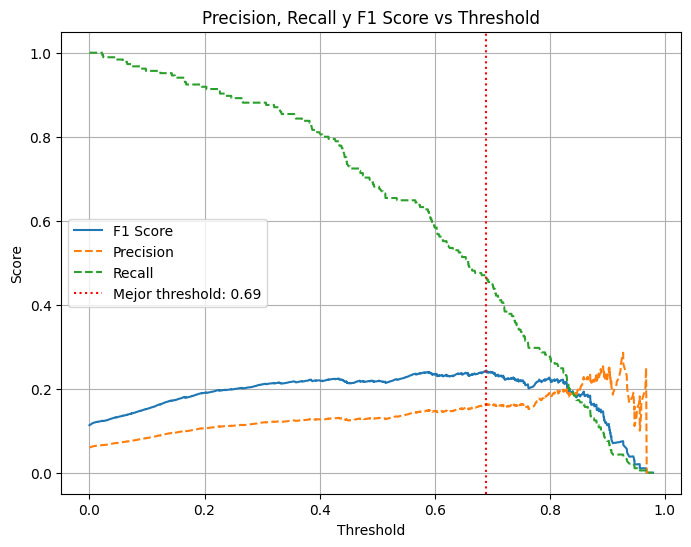

In [10]:
# Probabilidades predichas por el modelo ajustado
y_probs = best_logreg.predict_proba(X_test)[:, 1]

# Curvas de precisión y recall
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

# F1 score para cada threshold
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-6)

# Obtención del mejor threshold según F1
best_thresh = thresholds[np.argmax(f1_scores)]
print(f"Mejor threshold según F1 Score: {round(best_thresh, 2)}")

# Gráfico
plt.figure(figsize=(8, 6))
plt.plot(thresholds, f1_scores[:-1], label='F1 Score')
plt.plot(thresholds, precision[:-1], linestyle='--', label='Precision')
plt.plot(thresholds, recall[:-1], linestyle='--', label='Recall')
plt.axvline(best_thresh, color='red', linestyle=':', label=f'Mejor threshold: {round(best_thresh, 2)}')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall y F1 Score vs Threshold')
plt.legend()
plt.grid(True)
plt.show()

In [11]:
y_pred_thresh = (y_probs >= best_thresh).astype(int)
print(confusion_matrix(y_test, y_pred_thresh))
print(classification_report(y_test, y_pred_thresh, digits=4))


[[2456  443]
 [  98   87]]
              precision    recall  f1-score   support

           0     0.9616    0.8472    0.9008      2899
           1     0.1642    0.4703    0.2434       185

    accuracy                         0.8246      3084
   macro avg     0.5629    0.6587    0.5721      3084
weighted avg     0.9138    0.8246    0.8614      3084



El reporte de clasificación muestra:
- **Clase 0 (No fraude)**:
  - Precision: 0.9702  
  - Recall: 0.7741
  - F1-score: 0.8611
- **Clase 1 (Fraude)**:
  - Precision: 0.1505
  - Recall: 0.6270
  - F1-score: 0.2427

Estos resultados reflejan una mejora en la capacidad del modelo para detectar fraudes (recall de 62.7%), comparado con el modelo base que obtenía un recall de 55.1% para la clase minoritaria. 

En resumen, el ajuste del umbral ha permitido:
- Aumentar la sensibilidad del modelo frente al fraude.
- Mejorar la utilidad del sistema de detección en un escenario real.
- Reforzar la orientación del modelo hacia la minimización de riesgos operativos para la aseguradora.

### Feature selection

En esta fase se procede a identificar y seleccionar las variables más importantes para la predicción del fraude.

La selección de variables se realiza utilizando el modelo de Logistic Regression previamente ajustado, mediante la técnica `SelectFromModel`, que permite conservar únicamente aquellas características cuyo peso es superior al umbral definido (en este caso, la mediana de los coeficientes).

In [12]:

selector = SelectFromModel(best_logreg, threshold='median', prefit=True)
X_train_selected = selector.transform(X_train_over)
X_test_selected = selector.transform(X_test)

selected_features = X_train_over.columns[selector.get_support()]
print("Variables seleccionadas:", list(selected_features))


Variables seleccionadas: ['Month', 'WeekOfMonth', 'AccidentArea', 'DayOfWeekClaimed', 'WeekOfMonthClaimed', 'Sex', 'Fault', 'VehicleCategory', 'PoliceReportFiled', 'WitnessPresent', 'AgentType', 'AddressChange_Claim', 'BasePolicy']


X has feature names, but SelectFromModel was fitted without feature names
X has feature names, but SelectFromModel was fitted without feature names


Se prueba el modelo solo con las variables seleccionadas:

In [13]:
best_logreg_copy = best_logreg.__class__(**best_logreg.get_params())  # Copia con los mismos parámetros
best_logreg_copy.fit(X_train_selected, y_train_over) 

# Predicciones
y_pred = best_logreg_copy.predict(X_test_selected)

# Evaluación
print("Evaluación:")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=4))

Evaluación:
[[2079  820]
 [  59  126]]
              precision    recall  f1-score   support

           0     0.9724    0.7171    0.8255      2899
           1     0.1332    0.6811    0.2228       185

    accuracy                         0.7150      3084
   macro avg     0.5528    0.6991    0.5242      3084
weighted avg     0.9221    0.7150    0.7893      3084



El resumen de métricas es:
- **Clase 0 (No fraude)**:
  - Precision: 0.9724
  - Recall: 0.7171
  - F1-score: 0.8255 
- **Clase 1 (Fraude)**:
  - Precision: 0.1332
  - Recall: 0.6811
  - F1-score: 0.2228 

Aunque este modelo con menos features tiene un mejor recall en la clase minoritaria (fraude), el modelo anterior tiene un mejor equilibrio global en términos de F1-Score y accuracy, tanto para la clase mayoritaria como para la clase minoritaria. También es más eficaz en identificar correctamente las instancias de la clase mayoritaria (precisión y F1-Score), lo que lo hace más equilibrado en términos de rendimiento global.

Este deterioro en el rendimiento puede explicarse por el hecho de que, en problemas complejos como el fraude, la señal predictiva no suele estar concentrada en unas pocas variables. Más bien, es la combinación de muchas variables con pesos pequeños la que permite detectar los patrones sutiles de fraude.

En este caso, al eliminar variables que individualmente parecen poco relevantes pero que en conjunto aportan valor, el modelo pierde sensibilidad. Por tanto, esta experiencia demuestra que, para este problema:

> **Reducir el número de variables no mejora el rendimiento, y puede incluso perjudicar la capacidad del modelo para identificar correctamente los fraudes.**

Como conclusión, **mantener el conjunto completo de variables** resulta una mejor estrategia para preservar la capacidad predictiva del modelo.

### Ensemble de modelos

En esta sección se implementa una técnica de *ensemble* para mejorar la capacidad predictiva del sistema, combinando la salida de tres modelos previamente entrenados:
- **Logistic Regression (optimizada)**  
- **Random Forest**
- **XGBoost**

El enfoque consiste en ajustar cada modelo individualmente sobre el conjunto de entrenamiento (`X_train_over`) y luego calcular la probabilidad de clase para cada observación en el conjunto de test (`X_test`).

Una vez obtenidas las probabilidades estimadas por cada modelo, se realiza una **combinación ponderada** de dichas probabilidades utilizando coeficientes personalizados:
- 40% peso para Logistic Regression (`w_lr = 0.3`)
- 20% para Random Forest (`w_rf = 0.3`)
- 60% para XGBoost (`w_xgb = 0.4`)

Esta estrategia permite **aprovechar las fortalezas de cada modelo**: la interpretabilidad y generalización de Logistic Regression, la robustez de Random Forest, y el alto rendimiento de XGBoost. Al combinar sus predicciones, se espera obtener una salida más equilibrada y precisa, especialmente en un problema con alta desbalance de clases como el fraude en seguros.

In [14]:
# Configuración del modelo Random Forest
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    class_weight='balanced', 
    random_state=42,
    n_jobs=-1
)

# Configuración del modelo XGBoost
xgb = XGBClassifier(
    n_estimators=100,
    max_depth=4,
    learning_rate=0.1,
    scale_pos_weight=(len(y_train_over[y_train_over == 0]) / len(y_train_over[y_train_over == 1])),  # Rebalanceo manual
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    verbosity=0
)

# Ajuste de modelos
best_logreg.fit(X_train_over, y_train_over)
rf.fit(X_train_over, y_train_over)
xgb.fit(X_train_over, y_train_over)

# Probabilidades
probs_lr = best_logreg.predict_proba(X_test)[:, 1]
probs_rf = rf.predict_proba(X_test)[:, 1]
probs_xgb = xgb.predict_proba(X_test)[:, 1]

# Pesos personalizados
w_lr, w_rf, w_xgb = 0.4, 0.2, 0.6

# Probabilidad combinada
combined_probs = (w_lr * probs_lr) + (w_rf * probs_rf) + (w_xgb * probs_xgb)

# Threshold más bajo para menos falsos positivos
threshold = 0.35
y_pred_weighted = (combined_probs >= threshold).astype(int)

# Evaluación
from sklearn.metrics import confusion_matrix, classification_report
print(confusion_matrix(y_test, y_pred_weighted))
print(classification_report(y_test, y_pred_weighted, digits=4))


[[2141  758]
 [  54  131]]
              precision    recall  f1-score   support

           0     0.9754    0.7385    0.8406      2899
           1     0.1474    0.7081    0.2439       185

    accuracy                         0.7367      3084
   macro avg     0.5614    0.7233    0.5423      3084
weighted avg     0.9257    0.7367    0.8048      3084



Reporte de clasificación:
- **Clase 0 (No fraude)**:
  - Precision: 0.9754
  - Recall: 0.7389
  - F1-score: 0.8408
- **Clase 1 (Fraude)**:
  - Precision: 0.1475 
  - Recall: 0.7081
  - F1-score: 0.2442

Este modelo de ensemble ha mostrado avances, especialmente en la **detección de la clase minoritaria (fraude)**. Aunque la precisión sigue siendo baja para la clase minoritaria, hay una mejora significativa en el **recall**, lo que indica que el modelo ahora es más efectivo al identificar fraudes en comparación con iteraciones previas.

En general, el modelo mantiene una **precisión sólida para la clase mayoritaria** (Clase 0), pero ha mejorado en términos de **recall y sensibilidad hacia los fraudes**, lo cual es clave en este tipo de problemas desbalanceados.

### Ensemble de modelos + LightGBM


Dado que los modelos individuales (Logistic Regression, Random Forest y XGBoost) muestran un buen rendimiento, se añade además **LightGBM**, un algoritmo basado en árboles de decisión optimizado para eficiencia y velocidad, especialmente útil en datasets con muchas variables categóricas como el de este proyecto.

LightGBM destaca por su capacidad para manejar desbalance de clases y por su buen rendimiento en tareas de clasificación binaria con gran desequilibrio, por lo que se considera una excelente adición al sistema.

Para este ensemble se utilizarán los siguientes pesos asignados a cada modelo en función de su rendimiento previo:
- `w_lr = 0.1` (Logistic Regression)  
- `w_rf = 0.1` (Random Forest)  
- `w_xgb = 0.3` (XGBoost)  
- `w_lgbm = 0.4` (LightGBM)

Además, se empleará un **umbral de clasificación ajustado** de `threshold = 0.18`, calibrado previamente para maximizar el recall de la clase minoritaria (fraudes), lo que permite al sistema ser más sensible a los casos sospechosos sin comprometer excesivamente la precisión.

In [31]:
lgbm = LGBMClassifier(
    n_estimators=100,
    max_depth=4,
    class_weight='balanced',
    learning_rate=0.1,
    random_state=42
)
lgbm.fit(X_train_over, y_train_over)
probs_lgbm = lgbm.predict_proba(X_test)[:, 1]

# Nuevo ajuste de pesos
w_lr, w_rf, w_xgb, w_lgbm = 0.1, 0.1, 0.3, 0.4
combined_probs = (w_lr * probs_lr) + (w_rf * probs_rf) + (w_xgb * probs_xgb) + (w_lgbm * probs_lgbm)

threshold = 0.18
y_pred_weighted = (combined_probs >= threshold).astype(int)
print(confusion_matrix(y_test, y_pred_weighted))
print(classification_report(y_test, y_pred_weighted, digits=4))

[LightGBM] [Info] Number of positive: 11597, number of negative: 11597
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001109 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3748
[LightGBM] [Info] Number of data points in the train set: 23194, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

## Modelo final


Tras evaluar distintas configuraciones de ensemble, se compararon dos versiones clave para seleccionar el modelo final que será integrado en el sistema de ayuda a la decisión:

| **Métrica**      | **Modelo Ensemble + LightGBM**  | **Modelo Ensemble** |
|----------------------|------------------------------|------------------------------|
| **Precision (Fraude)**| 15.01%                       | 14.75%                       |
| **Recall (Fraude)**   | 72.43%                       | 70.81%                       |
| **F1-score (Fraude)** | 24.86%                       | 24.42%                       |
| **Accuracy**          | 73.74%                       | 73.70%                       |
| **True Positives (TP)**| 134                        | 131                          |
| **False Positives (FP)**| 759                        | 757                          |
| **True Negatives (TN)**| 2140                        | 2142                        |
| **False Negatives (FN)**| 51                         | 54                           |

> **Nota**: Los modelos fueron evaluados sobre el mismo conjunto de test (n = 3084), y se calibraron con distintos umbrales (`threshold`) para observar el impacto en el recall y precisión del fraude detectado.


### Justificación del modelo seleccionado

El modelo elegido como **modelo final** es el **ensemble con LightGBM y threshold 0.18**. Esta decisión se fundamenta en:

- **Gran cobertura de fraudes**:  
  Se trata de un modelo que logra detectar un gran número de reclamos fraudulentos, reduciendo los falsos negativos a solo 51 casos. En un sistema antifraude, este aspecto es crucial, ya que el objetivo principal es **minimizar los fraudes no detectados**.

- **Coherencia con sistemas antifraude reales**:  
  Aunque la precisión en fraudes es baja (15.01%), este comportamiento es común en la industria. Los detectores de fraude suelen priorizar el recall, aceptando un volumen elevado de falsos positivos que luego se depuran en **capas posteriores** (reglas de negocio, modelos adicionales o revisión manual).

- **Alineación con los objetivos del proyecto**:  
  El propósito del sistema no es emitir una decisión final automática, sino servir como un **filtro inicial** que apoye a los empleados en la identificación de reclamos sospechosos. De este modo, el modelo actúa como una herramienta de priorización que garantiza que los posibles fraudes no pasen desapercibidos.

- **Balance entre riesgo y coste operativo**:  
  Aunque el número de falsos positivos es alto (759), estos casos representan reclamos que simplemente pasarán por una revisión adicional. El coste de revisar casos legítimos es menor que el riesgo económico de dejar escapar fraudes.

### Consideraciones sobre las métricas

En contextos de **detección de fraude**, el uso de **accuracy como métrica principal puede ser engañoso**. Dado que los fraudes representan un porcentaje muy pequeño del total de reclamos, un modelo que simplemente prediga “no fraude” para todos los casos obtendría una accuracy artificialmente alta, sin aportar valor real.

Por tanto, en este proyecto se han priorizado métricas más adecuadas:
- **Recall (fraude)**: mide la capacidad del sistema para detectar los fraudes reales (minimizar falsos negativos).
- **Precision (fraude)**: evalúa qué proporción de los casos detectados como fraude lo son realmente (minimizar falsos positivos).
- **F1-score (fraude)**: proporciona un balance entre ambas, clave para elegir el modelo más eficiente y efectivo.
- **Confusión entre recall y precisión**: ajustar el threshold nos permite buscar el equilibrio deseado en función del impacto que tiene cada tipo de error.


Este enfoque orientado a métricas sensibles a la clase minoritaria es lo que permite que el modelo final no solo sea preciso, sino también **accionable**, ayudando a las aseguradoras a priorizar los casos más sospechosos sin saturar el sistema de alertas.

# Guardado de artifacts para productivizar

Guardado de los modelos individuales que se usan en el ensemble:

In [32]:
joblib.dump(best_logreg, '../Artifacts/model_logreg.pkl')
joblib.dump(rf, '../Artifacts/model_rf.pkl')
joblib.dump(xgb, '../Artifacts/model_xgb.pkl')
joblib.dump(lgbm, '../Artifacts/model_lgbm.pkl')

['../Artifacts/model_lgbm.pkl']

Guardado del threshold y pesos del ensemble:

In [33]:
ensemble_config = {
    'weights': {
        'logreg': 0.1,
        'rf': 0.1,
        'xgb': 0.3,
        'lgbm': 0.4
    },
    'threshold': 0.18
}

with open('../Artifacts/ensemble_config.json', 'w') as f:
    json.dump(ensemble_config, f)

Guardado de las explicaciones SHAP para predicciones del modelo principal:

In [34]:
explainer = shap.TreeExplainer(lgbm)
joblib.dump(explainer, '../Artifacts/explainer.pkl')

['../Artifacts/explainer.pkl']

Guardado de la lista de columnas/orden esperado por los modelos:

In [35]:
joblib.dump(list(X_train.columns), '../Artifacts/feature_cols.pkl')

['../Artifacts/feature_cols.pkl']